# Pneumonia Detection Using Deep Learning

This notebook explores the **PneumoniaMNIST** dataset from MedMNIST, containing chest X-ray images labeled as either **pneumonia-positive** or **normal**. 
## **Task Overview**
- **Objective:** Detect pneumonia in lung X-ray images
- **Dataset:** PneumoniaMNIST (from MedMNIST)
- **Approach:** Experiment with different deep learning models
---

# **Dataset Visualization**

## **Load & Explore the Dataset**
- Load **training, validation, and test datasets**
- **Visualize Normal vs Pneumonia lung X-rays** for better understanding


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from medmnist import PneumoniaMNIST
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim

2025-03-14 02:39:37.557022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 02:39:37.557067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 02:39:37.558414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 02:39:37.569840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using downloaded and verified file: /home/chynson/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /home/chynson/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /home/chynson/.medmnist/pneumoniamnist_224.npz


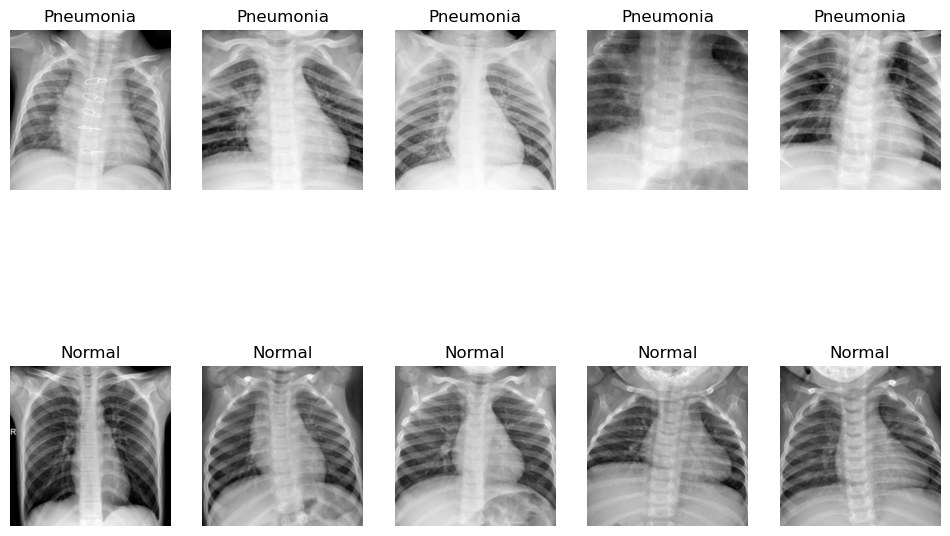

In [2]:
if 'dataset_train' not in globals():
    dataset_train = PneumoniaMNIST(split="train", download=True, size=224)
    dataset_val = PneumoniaMNIST(split="val", download=True, size=224)
    dataset_test = PneumoniaMNIST(split="test", download=True, size=224)

# Visualizing Pneumonia vs Normal Lungs
pneumonia_images = [dataset_train[i][0] for i in range(len(dataset_train)) if dataset_train[i][1] == 1][:5]
normal_images = [dataset_train[i][0] for i in range(len(dataset_train)) if dataset_train[i][1] == 0][:5]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
for i in range(5):
    
    # Pneumonia images
    image_pneumonia = np.array(pneumonia_images[i]) if isinstance(pneumonia_images[i], Image.Image) else pneumonia_images[i]
    axes[0][i].imshow(image_pneumonia, cmap='gray')
    axes[0][i].axis('off')
    axes[0][i].set_title("Pneumonia")
    
    # Normal images
    image_normal = np.array(normal_images[i]) if isinstance(normal_images[i], Image.Image) else normal_images[i]
    axes[1][i].imshow(image_normal, cmap='gray')
    axes[1][i].axis('off')
    axes[1][i].set_title("Normal")
plt.show()

# **Preprocessing & DataLoader**
- Converts images to **grayscale format** `(1, 224, 224)`
- Applies transformations like **resizing** and **normalization**
- Wraps the dataset in a **PyTorch `Dataset` class** for easy use with DataLoaders

In [3]:
class PneumoniaDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image, dtype=np.float32) / 255.0

        # ensure grayscale images have a single channel (1, H, W)
        if len(image.shape) == 2:  # if (H, W), convert to (1, H, W)
            image = np.expand_dims(image, axis=0)

        # convert to PIL Image only if a transformation is applied
        if self.transform:
            image = Image.fromarray((image.squeeze(0) * 255).astype(np.uint8))  # convert back to PIL format
            image = self.transform(image)  # transformations
        
        else:
            image = torch.tensor(image)  # convert NumPy array to Tensor manually

        label = torch.tensor(label, dtype=torch.long).squeeze()  # check label is a 1D tensor

        return image, label




# transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize before tensor conversion
    transforms.ToTensor(),  # Converts to tensor and keeps grayscale format (1, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
])


# Create PyTorch datasets
train_dataset = PneumoniaDataset(dataset_train, transform=transform)
val_dataset = PneumoniaDataset(dataset_val, transform=transform)
test_dataset = PneumoniaDataset(dataset_test, transform=transform)
print("Training Set Size:", len(train_dataset))
print("Validation Set Size:", len(val_dataset))
print("Test Set Size:", len(test_dataset))

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

USE_GPU = True
device = torch.device("cuda" if USE_GPU and torch.cuda.is_available() else "cpu")
print('Using device:', device)


Training Set Size: 4708
Validation Set Size: 524
Test Set Size: 624
Using device: cuda


# **Baseline Model: Simple Neural Network**

## **Purpose**
- This is our **first very simple model** to establish a **baseline accuracy**
- Uses a **fully connected network** with basic linear layers

## **Approach**
- **Architecture:**
  - **Flatten Input:** Converts image into a **1D vector**
  - **Fully Connected Layers:** Two dense layers process the data
  - **Output:** Binary classification (**Pneumonia vs. Normal**)
- **Training Strategy:**
  - Loss Function: **CrossEntropyLoss**
  - Optimizer: **Adam**
  - Runs for a **small number of epochs** to establish a baseline


In [4]:
from files.models import nn1
model = nn1()
print(model)

nn1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [5]:
dummy_input = torch.randn(1, 1, 224, 224)
output = model(dummy_input)
# print output shape (should be [1, 2] for binary classification)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 2])


In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# sample label (batch size = 1, class index 0 or 1)
label = torch.tensor([1])  # pneumonia

# forward pass
output = model(dummy_input)

# loss
loss = criterion(output, label)
print("Loss:", loss.item())

# backpropagation
loss.backward()
optimizer.step()

print("Backpropagation successful!")

Loss: 0.7577195167541504
Backpropagation successful!


In [7]:
from files.train import train_model

model = nn1().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10, Train Loss: 0.3478, Train Acc: 0.9174, Val Loss: 0.2279, Val Acc: 0.9046
Epoch 2/10, Train Loss: 0.1260, Train Acc: 0.9541, Val Loss: 0.1129, Val Acc: 0.9618
Epoch 3/10, Train Loss: 0.1077, Train Acc: 0.9616, Val Loss: 0.1181, Val Acc: 0.9542
Epoch 4/10, Train Loss: 0.0914, Train Acc: 0.9673, Val Loss: 0.1167, Val Acc: 0.9599
Epoch 5/10, Train Loss: 0.0809, Train Acc: 0.9705, Val Loss: 0.1421, Val Acc: 0.9370
Epoch 6/10, Train Loss: 0.0608, Train Acc: 0.9764, Val Loss: 0.1175, Val Acc: 0.9561
Epoch 7/10, Train Loss: 0.0649, Train Acc: 0.9730, Val Loss: 0.1635, Val Acc: 0.9466
Epoch 8/10, Train Loss: 0.0763, Train Acc: 0.9711, Val Loss: 0.1232, Val Acc: 0.9504
Epoch 9/10, Train Loss: 0.0421, Train Acc: 0.9845, Val Loss: 0.1445, Val Acc: 0.9561
Epoch 10/10, Train Loss: 0.0569, Train Acc: 0.9781, Val Loss: 0.2197, Val Acc: 0.9408
Training Complete!


In [8]:
from files.evaluate import test_model

# test evaluation
test_acc, report = test_model(model, test_loader, device)

Test Accuracy: 83.01%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.56      0.71       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



# **Optimizing Model Performance**

## **Analyzing Baseline Test Results**
- The baseline model achieved **83.01% test accuracy**, but let's break down the classification report

| Metric     | Normal (0) | Pneumonia (1) |
|------------|------------|------------|
| **Precision**  | 97% | 79% |
| **Recall**     | 56% | 99% |
| **F1-score**   | 71% | 88% |

### **Class Imbalance in Performance**
- The **Normal class** has high **precision (97%)**, but **low recall (56%)**
- The model is biased towards predicting **Pneumonia** (99% recall)

### **Potential Overfitting**
- **Training accuracy = 98.45%**, but **test accuracy = 83.01%**
- The model is **memorizing the training set** rather than generalizing well

### **Weighted Average F1-score = 0.82**
- The model performs well overall, but **misclassifications in Normal cases need to be addressed**

---

## **Next Steps: Improve Model Performance**
Now that we have a baseline, let's improve it using different strategies:

### **Method 1: Convolutional Neural Network (CNN)**
- The baseline model is a **fully connected neural network**, which doesn't capture **spatial features** so implementing a **CNN** will be able to detect **edges, textures, and shapes**, which are critical for **X-ray analysis**

## **CNN Architecture**
### **Layers Breakdown**
| Layer | Details |
|----------------|------------------------------------------------------|
| **Conv2D(16 filters, 3x3)** | Extracts **low-level features** like edges & textures |
| **ReLU Activation** | Applies non-linearity for better feature extraction |
| **MaxPooling(2x2)** | Reduces spatial dimensions by half (downsampling) |
| **Conv2D(32 filters, 3x3)** | Extracts more complex patterns |
| **ReLU Activation** | Another non-linear activation |
| **MaxPooling(2x2)** | Further reduces spatial dimensions |
| **Flatten** | Converts the **feature map** into a **1D vector** |
| **Fully Connected (128 neurons)** | Learns global patterns from extracted features |
| **Fully Connected (2 neurons, Softmax Output)** | Outputs **class probabilities** (Pneumonia vs Normal) |

In [10]:
from files.models import CNNModel

model_cnn = CNNModel().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# train
print("Training CNN Model...")
train_model(model_cnn, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Training CNN Model...
Epoch 1/10, Train Loss: 0.1823, Train Acc: 0.9344, Val Loss: 0.1345, Val Acc: 0.9427
Epoch 2/10, Train Loss: 0.0855, Train Acc: 0.9673, Val Loss: 0.1188, Val Acc: 0.9561
Epoch 3/10, Train Loss: 0.0623, Train Acc: 0.9783, Val Loss: 0.1266, Val Acc: 0.9580
Epoch 4/10, Train Loss: 0.0432, Train Acc: 0.9841, Val Loss: 0.1871, Val Acc: 0.9485
Epoch 5/10, Train Loss: 0.0286, Train Acc: 0.9877, Val Loss: 0.1084, Val Acc: 0.9656
Epoch 6/10, Train Loss: 0.0205, Train Acc: 0.9938, Val Loss: 0.1545, Val Acc: 0.9599
Epoch 7/10, Train Loss: 0.0085, Train Acc: 0.9970, Val Loss: 0.1451, Val Acc: 0.9599
Epoch 8/10, Train Loss: 0.0028, Train Acc: 0.9992, Val Loss: 0.1514, Val Acc: 0.9676
Epoch 9/10, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.1503, Val Acc: 0.9618
Epoch 10/10, Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.1546, Val Acc: 0.9637
Training Complete!


In [11]:
# test evaluation
test_acc, report = test_model(model_cnn, test_loader, device)

Test Accuracy: 82.69%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.56      0.71       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



## **CNN vs Baseline Model: Performance Comparison**

### **Test Results**
| Metric     | Baseline | CNN Model |
|------------|------------|------------|
| **Test Accuracy**  | **83.01%** | **82.69%** |
| **Precision (Normal)**  | **97%** | **97%** |
| **Recall (Normal)**     | **57%** | **56%** |
| **F1-score (Normal)**   | **72%** | **71%** |
| **Recall (Pneumonia)**  | **99%** | **99%** |

### **🔬 Key Takeaways**
- **CNN shows higher training & validation accuracy** but still favors Pneumonia
- **No significant test accuracy improvement**—overfitting remains an issue.  
---

## **Next Steps: Improving Model Performance with ResNet-18**
After implementing a **CNN**, we can further enhance performance by leveraging **deeper architectures**. **ResNet-18** utilizes **skip connections** to allow deeper networks to train effectively ultimately leading to better feature extraction and mitigating the vanishing gradient problem.

- **Two Approaches**: 
    1. **Train ResNet from scratch** (no pre-trained weights): Trained entirely from **random initialization**
    2. **Use a Pretrained ResNet** (leveraging Transfer Learning): Uses **pretrained ImageNet weights** for faster convergence

## **Method 2: ResNet-18 Architecture**
### **Layers Breakdown**
| Layer | Details |
|----------------|------------------------------------------------------|
| **Conv2D(64 filters, 7x7, stride=2, padding=3)** | Extracts **low-level features** like edges & textures |
| **Batch Normalization & ReLU Activation** | Improves stability and non-linearity |
| **MaxPooling(3x3, stride=2)** | Reduces spatial dimensions by half |
| **ResNet Blocks (Basic Blocks)** | Deep feature extraction via residual connections |
| **Adaptive Avg Pooling** | Reduces dimensions for final classification |
| **Fully Connected Layer (2 neurons, Softmax Output)** | Outputs class probabilities (Pneumonia vs Normal) |

In [13]:
from files.models import ResNetScratch, ResNetPretrained

model_scratch = ResNetScratch().to(device)
model_pretrained = ResNetPretrained().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
optimizer_pretrained = optim.Adam(model_pretrained.parameters(), lr=0.001)

print("Training ResNet from Scratch...")
train_model(model_scratch, train_loader, val_loader, criterion, optimizer_scratch, device, epochs=10)

print("\n Training Pretrained ResNet...")
train_model(model_pretrained, train_loader, val_loader, criterion, optimizer_pretrained, device, epochs=10)

Training ResNet from Scratch...
Epoch 1/10, Train Loss: 0.2523, Train Acc: 0.9034, Val Loss: 0.1916, Val Acc: 0.9218
Epoch 2/10, Train Loss: 0.1364, Train Acc: 0.9452, Val Loss: 0.1159, Val Acc: 0.9618
Epoch 3/10, Train Loss: 0.1090, Train Acc: 0.9533, Val Loss: 0.2398, Val Acc: 0.8989
Epoch 4/10, Train Loss: 0.1040, Train Acc: 0.9603, Val Loss: 0.0891, Val Acc: 0.9695
Epoch 5/10, Train Loss: 0.0904, Train Acc: 0.9664, Val Loss: 0.0684, Val Acc: 0.9714
Epoch 6/10, Train Loss: 0.0935, Train Acc: 0.9679, Val Loss: 0.1617, Val Acc: 0.9294
Epoch 7/10, Train Loss: 0.0809, Train Acc: 0.9711, Val Loss: 0.1237, Val Acc: 0.9542
Epoch 8/10, Train Loss: 0.0707, Train Acc: 0.9707, Val Loss: 0.0726, Val Acc: 0.9733
Epoch 9/10, Train Loss: 0.0594, Train Acc: 0.9777, Val Loss: 0.4221, Val Acc: 0.8607
Epoch 10/10, Train Loss: 0.0560, Train Acc: 0.9781, Val Loss: 0.0692, Val Acc: 0.9752
Training Complete!

 Training Pretrained ResNet...
Epoch 1/10, Train Loss: 0.1460, Train Acc: 0.9486, Val Loss: 0.113

In [14]:
from files.evaluate import test_model

print("Evaluating ResNet from Scratch...")
test_model(model_scratch, test_loader, device)

print("\nEvaluating Pretrained ResNet...")
test_model(model_pretrained, test_loader, device)

Evaluating ResNet from Scratch...
Test Accuracy: 84.94%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.61      0.75       234
   Pneumonia       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624


Evaluating Pretrained ResNet...
Test Accuracy: 86.86%

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.65      0.79       234
   Pneumonia       0.83      1.00      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.85       624
weighted avg       0.89      0.87      0.86       624



(0.8685897435897436,
 '              precision    recall  f1-score   support\n\n      Normal       1.00      0.65      0.79       234\n   Pneumonia       0.83      1.00      0.90       390\n\n    accuracy                           0.87       624\n   macro avg       0.91      0.82      0.85       624\nweighted avg       0.89      0.87      0.86       624\n')

## **ResNet-18 Performance Analysis**
After training both **ResNet from Scratch** and **Pretrained ResNet**, let's compare their performance.

### **ResNet from Scratch**
| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|----------|---------|------------|------------|
| 1     | 90.3%    | 92.2%   | 0.2523     | 0.1916     |
| 5     | 96.6%    | 97.1%   | 0.0904     | 0.0684     |
| 10    | 97.8%    | 97.5%   | 0.0560     | 0.0692     |

- **Consistent performance** with stable validation accuracy
- **Slight overfitting** noticed at **Epoch 9** (val loss spiked to **0.4221**)

### **Pretrained ResNet (Transfer Learning)**
| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|----------|---------|------------|------------|
| 1     | 94.9%    | 96.9%   | 0.1460     | 0.1130     |
| 5     | 98.0%    | 96.4%   | 0.0501     | 0.1388     |
| 10    | 98.8%    | 97.9%   | 0.0343     | 0.0593     |

- **Faster convergence**, reaching high validation accuracy early 
- **Val loss spiked** at **Epoch 2** (**0.3969**, 85.1%), indicating some instability

### **Key Observations:**
| Model | Training Time | Final Test Accuracy | Stability | Overfitting Risk |
|---------|-------------|---------------------|-----------|------------------|
| **ResNet from Scratch** | Longer | **84.94%** | More stable | Moderate |
| **Pretrained ResNet** | Faster | **86.86%** | Some instability | Slightly higher |

- **Pretrained ResNet** **converged faster** but had minor **instability in early epochs**
- **ResNet from Scratch** had **more stable training** but required **longer training time**
- **Test Accuracy: 86.9%**
  - **Precision (Normal):** **100%**, but **recall = 65%** (still misclassifying Normal cases)
  - **Recall (Pneumonia):** **100%**, indicating **model bias toward Pneumonia**
---

## **Next Steps: Enhancing Feature Extraction**
After implementing **ResNet-18**, we now experiment with **even deeper architectures** that **capture more complex patterns in X-rays**.

- **Two Approaches**: 
    1. **CNN with Batch Norm & Dropout**: Improves generalization and prevents overfitting
    2. **ResNet-50 (Transfer Learning)**: A **deeper residual network** leveraging **pretrained ImageNet weights**

## **Method 3: Advanced Model Architectures**
### **CNN with Batch Normalization & Dropout**
| Layer | Details |
|----------------|------------------------------------------------------|
| **Conv2D(32 filters, 3x3, padding=1)** | Extracts **low-level features** like edges & textures |
| **BatchNorm & ReLU Activation** | Stabilizes training and improves feature extraction |
| **MaxPooling(2x2)** | Reduces spatial dimensions |
| **Conv2D(64 filters, 3x3, padding=1)** | Extracts higher-level features |
| **BatchNorm & ReLU Activation** | Improves non-linearity |
| **MaxPooling(2x2)** | Further reduces spatial dimensions |
| **Fully Connected (256 neurons, Dropout 0.5)** | Prevents overfitting |
| **Fully Connected (2 neurons, Softmax Output)** | Outputs class probabilities |

### **ResNet-50**
| Layer | Details |
|----------------|------------------------------------------------------|
| **Conv2D(64 filters, 7x7, stride=2, padding=3)** | Extracts **low-level features** |
| **Batch Normalization & ReLU Activation** | Improves stability and non-linearity |
| **MaxPooling(3x3, stride=2)** | Reduces spatial dimensions |
| **Deeper ResNet Blocks (50 layers)** | Extracts advanced features with **skip connections** |
| **Adaptive Avg Pooling** | Reduces dimensions for classification |
| **Fully Connected Layer (2 neurons, Softmax Output)** | Outputs class probabilities |

In [26]:
from files.models import CNNModelAdvanced, ResNet50Pretrained

model_cnn = CNNModelAdvanced().to(device)
model_resnet50 = ResNet50Pretrained().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001)

print("Training CNN with Batch Normalization & Dropout...")
train_model(model_cnn, train_loader, val_loader, criterion, optimizer_cnn, device, epochs=10)

print("\nTraining ResNet-50...")
train_model(model_resnet50, train_loader, val_loader, criterion, optimizer_resnet50, device, epochs=10)

Training CNN with Batch Normalization & Dropout...
Epoch 1/10, Train Loss: 1.7324, Train Acc: 0.9212, Val Loss: 0.0940, Val Acc: 0.9637
Epoch 2/10, Train Loss: 0.1242, Train Acc: 0.9567, Val Loss: 0.1085, Val Acc: 0.9695
Epoch 3/10, Train Loss: 0.1154, Train Acc: 0.9588, Val Loss: 0.1035, Val Acc: 0.9580
Epoch 4/10, Train Loss: 0.1344, Train Acc: 0.9573, Val Loss: 0.0800, Val Acc: 0.9676
Epoch 5/10, Train Loss: 0.0982, Train Acc: 0.9652, Val Loss: 0.1828, Val Acc: 0.9389
Epoch 6/10, Train Loss: 0.1218, Train Acc: 0.9558, Val Loss: 0.1689, Val Acc: 0.9580
Epoch 7/10, Train Loss: 0.1041, Train Acc: 0.9605, Val Loss: 0.1064, Val Acc: 0.9637
Epoch 8/10, Train Loss: 0.1238, Train Acc: 0.9522, Val Loss: 0.0997, Val Acc: 0.9523
Epoch 9/10, Train Loss: 0.1302, Train Acc: 0.9518, Val Loss: 0.1440, Val Acc: 0.9618
Epoch 10/10, Train Loss: 0.1198, Train Acc: 0.9533, Val Loss: 0.0920, Val Acc: 0.9695
Training Complete!

Training ResNet-50...
Epoch 1/10, Train Loss: 0.1642, Train Acc: 0.9367, Val L

In [27]:
print("Evaluating CNN with Batch Normalization & Dropout...")
test_acc_cnn, report_cnn = test_model(model_cnn, test_loader, device)

print("\nEvaluating ResNet-50...")
test_acc_resnet50, report_resnet50 = test_model(model_resnet50, test_loader, device)


Evaluating CNN with Batch Normalization & Dropout...
Test Accuracy: 87.18%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.68      0.80       234
   Pneumonia       0.84      0.98      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624


Evaluating ResNet-50...
Test Accuracy: 85.10%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.61      0.75       234
   Pneumonia       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



# **Final Model Comparison: CNN with Batch Norm & Dropout vs. ResNet-50**

## **Key Observations**

**CNN with BatchNorm & Dropout**:
- Achieved the **highest test accuracy (87.18%)**
- More **balanced recall** between **Normal (68%)** and **Pneumonia (98%)**
- **Stronger generalization**, with **better performance across both classes**

**ResNet-50**:
- Achieved **85.10% test accuracy** but has **higher precision (99%)** for Normal cases
- **Poor recall (61%)** for Normal cases—**over-predicts Pneumonia**
- **Signs of overfitting**: Training accuracy reached **99.55%**, but validation fluctuated
- A **sudden validation loss spike (Epoch 4: 1.43)** suggests instability

| Model | Test Accuracy | Normal Precision | Normal Recall | Pneumonia Precision | Pneumonia Recall | F1-Score (Weighted) |
|------------|---------------|----------------|---------------|-------------------|------------------|------------------|
| **CNN (BatchNorm + Dropout)** | **87.18%** | 96% | **68%** | **84%** | **98%** | **87%** |
| **ResNet-50 (Transfer Learning)** | 85.10% | **99%** | 61% | 81% | 100% | 84% |



---



## Potential Architecture Improvements

To further enhance model performance and mitigate **recall imbalance**, several architectural modifications could be introduced:

### **Increase Model Depth & Capacity**
- **Add more convolutional layers** to capture deeper spatial features
- **Use larger kernel sizes (5x5 or 7x7)** for broader feature extraction

### **Implement Squeeze-and-Excitation (SE) Blocks**
- Introduces **attention mechanisms** to focus on pneumonia-affected lung regions

### **Optimize Regularization Techniques**
- **Fine-tune Dropout (0.3-0.4 instead of 0.5)** to retain more informative neurons
- **Use L2 Weight Decay (1e-4)** to reduce overfitting



By integrating these enhancements, the model can **increase recall while maintaining balanced performance**, making it more reliable for real-world pneumonia detection.
